In [120]:
import os
import pandas as pd
import pandas_gbq
import pytz
import io
import numpy as np
import seaborn as sns
from dbfread import DBF

# import plotly libraries
import plotly as py
import plotly.graph_objects as go
import plotly.express as px 
import ipywidgets as widgets

#import arcgis libraries
from arcgis.gis import *
gis = GIS()

In [63]:
#google cloud big query libraries
from google.cloud import bigquery
from google.oauth2 import service_account

key_path = r"C:\Users\cday\tdm-scenarios-c90ba30c3c5d.json"

credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)
 
client = bigquery.Client(credentials=credentials, project=credentials.project_id,)

### Read in Scenarios and Segment Summary Outputs

In [6]:
ScenarioTableID = 'tdm-scenarios.tdm_scenarios_output.scenarios'
scenarios = client.query("SELECT * FROM " + ScenarioTableID).to_dataframe()

SegmentTableID = 'tdm-scenarios.tdm_scenarios_output.segment_summary'
segment_summary = client.query("SELECT * FROM " + SegmentTableID).to_dataframe()

dfSegSum = pd.merge(segment_summary, scenarios, left_on = 'scenarioID', right_on = 'scenarioID', how = 'left')
dfSegSum = dfSegSum.sort_values('scenarioID')

## Create Graphics to show changes between 2 scenarios

In [ ]:
scenario1 = 4
scenario2 = 15

In [47]:
dfMean = dfSegSum.groupby('scenarioID').mean()

TypeError: ufunc 'log' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

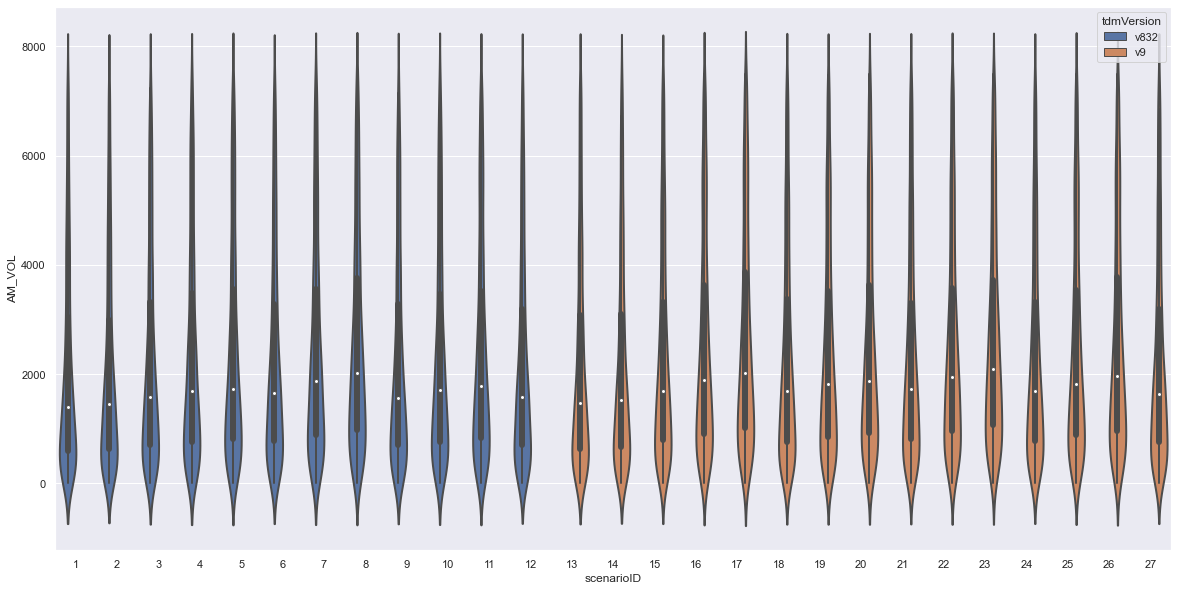

In [60]:
maxValue = 7500
sns.set(rc={'figure.figsize':(20,10)})

vp = sns.violinplot(data=dfSegSum, 
               x="scenarioID", 
               y=dfSegSum[dfSegSum["AM_VOL"]<maxValue]["AM_VOL"],
               hue ="tdmVersion",
               linewidth = 2,
               showfliers = False
              )
#g = sns.FacetGrid(dfSegSum, row="FT")
#g.map(sns.violinplot, 'AM_VOL', 'scenarioID')

### Summary Statistics using Violin Plots

In [15]:
def plot_violin(scenarioOptions, ftOptions, varOption):
    data = []
    for scenarios in scenarioOptions:
        for fts in ftOptions:
            # data for plotting from filtered dataframe
            if fts == 'All':
                plotdata = dfSegSum[(dfSegSum['scenarioID']==scenarios)]
            else:
                plotdata = dfSegSum[(dfSegSum['scenarioID']==scenarios) & (dfSegSum['FTCLASS']==fts)]
            plotdata = plotdata.fillna(0)

            trace1 =  go.Violin(
                x = plotdata['scenarioID'],
                y = plotdata[varOption],
                name = 'Scenario ' + str(scenarios),
                box_visible = True
            )
            data.append(trace1)
                
    layout2 = go.Layout(
        title='Segment Summary Stats for' +' FTCLASS: ' + fts,
        yaxis=dict(
            title='Amount'
        ),
        xaxis=dict(
            title='Scenarios'
        ),
        #width=1600,
        height=450
    )
    
    fig = go.Figure(data=data, layout=layout2)
    py.offline.iplot(data)

In [1]:
# MAKE INTERACTIVE CHART
py.offline.init_notebook_mode(connected=True)

lstFTType = dfSegSum['FTCLASS'].unique().tolist()
lstFTType.append('All')
lstScenario = list(set(dfSegSum.scenarioID.tolist()))
lstVars = ['DIST_1WY', 'LANES','CAP1HL', 'AM_VOL', 'MD_VOL', 'PM_VOL', 'EV_VOL', 'DY_VOL', 'DY_LT', 'DY_MD', 'DY_HV', 'FF_SPD', 'AM_SPD', 'MD_SPD', 'PM_SPD', 'EV_SPD', 'DY_SPD', 'D1_LINKS', 'D1_DIST', 'D1_LANES', 'D1_FT', 'D1_FTCLASS', 'D1_CAP1HL', 'D1_AM_VOL', 'D1_MD_VOL', 'D1_PM_VOL', 'D1_EV_VOL', 'D1_DY_VOL', 'D1_DY_LT', 'D1_DY_MD', 'D1_DY_HV', 'D1_FF_SPD', 'D1_AM_SPD', 'D1_MD_SPD', 'D1_PM_SPD', 'D1_EV_SPD', 'D1_DY_SPD', 'D2_LINKS', 'D2_DIST', 'D2_LANES', 'D2_FT', 'D2_FTCLASS', 'D2_CAP1HL', 'D2_AM_VOL', 'D2_MD_VOL', 'D2_PM_VOL', 'D2_EV_VOL', 'D2_DY_VOL', 'D2_DY_LT', 'D2_DY_MD', 'D2_DY_HV', 'D2_FF_SPD', 'D2_AM_SPD', 'D2_MD_SPD', 'D2_PM_SPD', 'D2_EV_SPD', 'D2_DY_SPD']
    
selectFTType       = widgets.SelectMultiple(options=lstFTType    , value=('Collector',)    , description='FTCLASS' )
selectScenario     = widgets.SelectMultiple(options=lstScenario  , value=(1 ,)             , description='Scenario')
selectVars         = widgets.Select        (options=lstVars      , value=('AM_VOL')        , description='Variable')

widgets.interactive(plot_violin, scenarioOptions = selectScenario, ftOptions = selectFTType, varOption = selectVars)

NameError: name 'py' is not defined

### Summary Statistics using Maps

In [125]:
dirSegShp = r'A:\1 - TDM\1 - Input Dev\6 - Segment\0 - Segment Shapefile\Master_Segs_withFactors_20220915\Master_Segs_withFactors_20220915shp.shp'

#import into spatially-enabled DataFrame
sdf_Forecasts = pd.DataFrame.spatial.from_featureclass(dirSegShp)
sdf_Forecasts_short = sdf_Forecasts[['SEGID','SHAPE']]

In [130]:
sScenario = 'S50_WithOp'
sVCGroup  = 'AnnWkPMPrd'

map_seg = gis.map('Salt Lake')

##expression to classify enrollment
#arcade_expression = ("var v = $feature." + sVCGroup + ";"
#                     "var ft = $feature.FT;"
#                     "if      (v<0.7  && ft<10) { return 'class_a1'; }"
#                     "else if (v<0.85 && ft<10) { return 'class_a2'; }"
#                     "else if (v<1.0  && ft<10) { return 'class_a3'; }"
#                     "else if (v<1.5  && ft<10) { return 'class_a4'; }"
#                     "else if (v>=1.5 && ft<10) { return 'class_a5'; }"
#                     "else if (v<0.7  && ft>10) { return 'class_f1'; }"
#                     "else if (v<0.85 && ft>10) { return 'class_f2'; }"
#                     "else if (v<1.0  && ft>10) { return 'class_f3'; }"
#                     "else if (v<1.5  && ft>10) { return 'class_f4'; }"
#                     "else if (v>=1.5 && ft>10) { return 'class_f5'; }"
#                    )
#
##symbology for enrollment classes
#uv = [{"value":"class_a1", "label":"Arterial Less than 0.70", "symbol":{"type":"esriSLS","color":[  0,255,  0,160], "width":1.5,"style":"esriSLSSolid"}},
#      {"value":"class_a2", "label":"Arterial 0.70 to 0.85"  , "symbol":{"type":"esriSLS","color":[169,243,106], "width":1.5,"style":"esriSLSSolid"}},
#      {"value":"class_a3", "label":"Arterial 0.85 to 1.00"  , "symbol":{"type":"esriSLS","color":[255,228,105], "width":1.5,"style":"esriSLSSolid"}},
#      {"value":"class_a4", "label":"Arterial 1.00 to 1.50"  , "symbol":{"type":"esriSLS","color":[255,  0,  0], "width":1.5,"style":"esriSLSSolid"}},
#      {"value":"class_a5", "label":"Arterial More than 1.50", "symbol":{"type":"esriSLS","color":[115,  0,  0], "width":1.5,"style":"esriSLSSolid"}},
#      {"value":"class_f1", "label":"Freeway Less than 0.70" , "symbol":{"type":"esriSLS","color":[  0,255,  0,160], "width":4.0,"style":"esriSLSSolid"}},
#      {"value":"class_f2", "label":"Freeway 0.70 to 0.85"   , "symbol":{"type":"esriSLS","color":[169,243,106], "width":4.0,"style":"esriSLSSolid"}},
#      {"value":"class_f3", "label":"Freeway 0.85 to 1.00"   , "symbol":{"type":"esriSLS","color":[255,228,105], "width":4.0,"style":"esriSLSSolid"}},
#      {"value":"class_f4", "label":"Freeway 1.00 to 1.50"   , "symbol":{"type":"esriSLS","color":[255,  0,  0], "width":4.0,"style":"esriSLSSolid"}},
#      {"value":"class_f5", "label":"Freeway More than 1.50" , "symbol":{"type":"esriSLS","color":[115,  0,  0], "width":4.0,"style":"esriSLSSolid"}}]
#
#idDisplay = idFromCode(sScenario)
#sTitle = "Congestion: " + ScenarioNameFromCode(sScenario) + ' - ' + SeasonNameFromCode(sVCGroup[0:3]) + ' ' + DOWPkNameFromCode(sVCGroup[3:7])
#


sdf_Forecasts_wVC = pd.DataFrame.merge(dfSegSum, sdf_Forecasts,left_on='SEGID',right_on='SEGID',how='left')
#display(sdf_Forecasts_wVC)
#
sdf_Forecasts_wVC = sdf_Forecasts_wVC[['SEGID','AM_VOL','SHAPE']]
#
#
##define sdf layer
sdf_Forecasts_wVC.spatial.plot(map_widget = map_seg,renderer_type='u-a',default_symbol="",arcade_title="V/C Ratio Range")
#
##define map characteristics
map_seg.layout.height='800px'
map_seg.legend=True
#
##map title
#display(Markdown('<h2><center>' + sTitle + '</center></h2>'))
#
##display map
map_seg

MapView(layout=Layout(height='800px', width='100%'), legend=True)

In [14]:
#import arcgis libraries
from arcgis.gis import *
gis = GIS()

#create map1 that centers on Salt Lake (can replace 'Salt Lake' with any place name or leave blank for entire world)
map1 = gis.map('Salt Lake')

#show map1
map1

MapView(layout=Layout(height='400px', width='100%'))

In [12]:
import folium
import geopandas as gpd

dirSegShp = r'A:\1 - TDM\1 - Input Dev\6 - Segment\0 - Segment Shapefile\Master_Segs_withFactors_20220915\Master_Segs_withFactors_20220915shp.shp'
segShp = gpd.read_file(dirSegShp)
segShp.head()


,Id,SEGID,BMP,EMP,DISTANCE,FULLNAME,FNCLASS,FC_CODE,FC_GROUP,FC_NAME,...,FAC_MAX,FACMANADJ,SUTRUCKS,CUTRUCKS,F2050,F2040,FORNOTES,ForecastSo,Shape_Leng,geometry
0,0,0006_000.0,0.000,0.665,0.666641,HWY 6,Arterial,3,Arterial,Other Principal Arterial,...,1.1065,0,0.2496,0.2324,600,550,None,Utah_Statewide_Traffic_Volume_Historic_and_For...,1072.856212,"LINESTRING (236177.700 4327541.250, 237241.180..."
1,0,0006_000.7,0.665,16.022,15.369839,HWY 6,Arterial,3,Arterial,Other Principal Arterial,...,1.1065,0,0.2496,0.2324,550,500,None,Utah_Statewide_Traffic_Volume_Historic_and_For...,24735.407823,"LINESTRING (237241.180 4327399.720, 238150.600..."
2,0,0006_016.0,16.022,46.017,30.001961,HWY 6,Arterial,3,Arterial,Other Principal Arterial,...,1.1065,0,0.2496,0.2324,550,500,None,Utah_Statewide_Traffic_Volume_Historic_and_For...,48283.572122,"LINESTRING (261403.900 4327045.400, 261409.000..."
3,0,0006_046.0,46.017,60.218,14.194306,HWY 6,Arterial,3,Arterial,Other Principal Arterial,...,1.1065,0,0.1751,0.3338,500,450,None,Utah_Statewide_Traffic_Volume_Historic_and_For...,22843.567118,"LINESTRING (305380.160 4325741.850, 305784.500..."
4,0,0006_060.2,60.218,77.545,17.323237,HWY 6,Arterial,3,Arterial,Other Principal Arterial,...,1.1065,0,0.1751,0.3338,500,450,None,Utah_Statewide_Traffic_Volume_Historic_and_For...,27879.103631,"LINESTRING (324618.000 4337936.900, 324647.400..."


In [13]:
#Define coordinates of where we want to center our map
boulder_coords = [40.015, -105.2705]

map_with_tiles = folium.Map(location = boulder_coords, tiles = 'Stamen Toner')
map_with_tiles
folium.PolyLine(segShp['geometry']).add_to(map_with_tiles)

TypeError: Location should be a sized variable, for example a list or a tuple, instead got <shapely.geometry.linestring.LineString object at 0x000002DB5CF59288> of type <class 'shapely.geometry.linestring.LineString'>.